In [1]:
### importing packages ###
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib as mpl
from tqdm import tqdm
import math
from decimal import Decimal

### 1. Defining the models as a functions

This model is essentially the same one I used in the practicals, I just added some more comments throughout.

In [2]:
### ICE SHEET MODEL ###

def ice_model(dt, time_total,                  #time increment [years], total time of the model run [years]
             dx, x_total,                      #spatial increment [m], total length of the ice sheet [m]
             e=10**(-4),                       #setting minimum ice thickness [m] (these are the automatic values that will be used if not explicitly specified)
             rho=917,                          #ice density [kg/m^3]
             g=9.8,                            #acceleration due to gravity [m/s^2]
             A=24*(10**(-25))*60*60*24*365.4,  #flow law parameter [Pa a]
             n=3):                             #flow law exponent

    #setup grids & empty thickness array to fill 
    time  = np.arange(0, time_total, dt)
    x     = np.arange(0, x_total, dx)
    H     = np.zeros((len(time), len(x))) #H[time, x]
    H[0,:]= e
    
    #surface mass balance
    b_i = 10**(-4) * ((x_total/3) - x)
    
    #ice thickness simulation
    for timestep in tqdm(np.arange(1,len(time))): #tqdm displays progress bar for loop

        # save the old thickness vector
        H_old  = H[timestep-1,:]

        # (1) compute H on the staggered grid
        H_stag = (H_old[1:] + H_old[:-1])/2

        # (2) compute the surface slope on the staggered grid.
        alpha = -(H_old[1:] - H_old[:-1])/dx 

        # (3) compute the flux on the staggered grid
        q = 2*A/(n+2) * (rho * g * alpha)**n * H_stag**(n+2)  

        # (4) compute the ice thickness at the current time step
        h_test = dt * (b_i[1:-1] - ((q[1:]-q[:-1])/dx)) + H_old[1:-1]
        h_test[h_test<0] = e 
        H[timestep, 1:-1] = h_test


        # apply the boundary conditions at x = 0 and x = X
        H[timestep,0] = H[timestep,1]
        H[timestep,-1] = e
        
    return x, time, H, q #the q is just the final flux
    

Really quickly I want to make sure the function is working correctly:

In [3]:
x, time, H, q = ice_model(2/365, 5000, 200, 40000)

100%|██████████| 912499/912499 [00:40<00:00, 22591.87it/s]


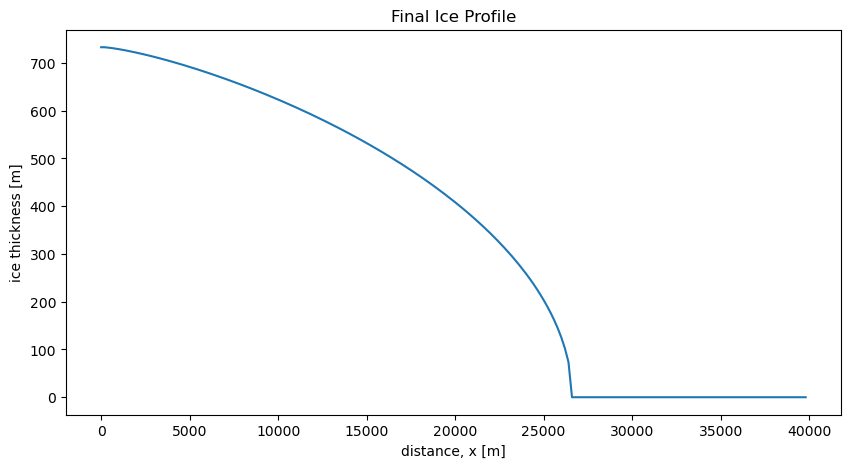

In [4]:
#plotting up the results for the final thickness
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, H[-1, :])
ax.set_xlabel('distance, x [m]')
ax.set_ylabel('ice thickness [m]')
ax.set_title('Final Ice Profile');

Looking good to me! Now I can move on to the heat flow model.

In [5]:
### HEAT FLOW MODEL ###

def heat_model(dt, time_total, #time increment [years], total time of the model run [years]
              dz, z_total,     #spatial increment [m], total height of the ice sheet [m]
              a_yr=0.1,        #accumulation [m/year]            
              T_surf = -20     #surface temperature [deg. C]
              ):        
    
    #constants
    seconds_per_year = 3.154 * 10**7 #seconds/year
    alpha            = 1.25e-6       #thermal diffusivity [k/rho_i/c]
    G                = 60e-3         #geothermal heat flux [mW/m^2]        
    k                = 2.3           #Thermal conductivity of ice at -10C [W/mK]
 
    #time grid
    dt_inseconds         = dt*seconds_per_year;        #converting dt to seconds
    time_total_inseconds = time_total*seconds_per_year #converting total time to seconds
    t = np.linspace(0,time_total_inseconds,round(time_total_inseconds/dt_inseconds))  #time grid [sec.]
    
    #space grid
    z = np.linspace(0,z_total,round(z_total/dz))  #spatial grid [m]
    
    #vertical ice velocity
    a = a_yr/seconds_per_year        #accumulation [m/second]
    w = -np.linspace(0,a,np.size(z)) #vertical velocity, sign convention is that up is positive, and we are assuming it varies from zero at the bed to a at the surface
    
    #temperature grid
    T = np.zeros((np.size(t),np.size(z))) #empty array to to fill as the model evolves [time, depth]
    
    #initial conditions
    T[0,:] = np.linspace(0,T_surf,np.size(z)) #intitial temp. profile
    
    ##TEMPERATURE SIMULATION##
    for timestep in tqdm(np.arange(1,len(t))): #tqdm displays progress bar for loop

        T[timestep,1:-1] = T[timestep-1,1:-1] + dt_inseconds * ( alpha *   ( T[timestep-1,2:]-2*T[timestep-1,1:-1]+T[timestep-1,:-2])/dz**2 - w[1:-1]*(T[timestep-1,2:]-T[timestep-1,:-2])/(2*dz) )   

        #boundary conditions
        T[timestep,-1] = T_surf;
        T[timestep,0] = T[timestep,1] + (G/k*dz)  
        
    return T, z       

Now I'll test the temperature model. I'll plot the final temperature profiles for a range of ice thicknesses.

100%|██████████| 29999/29999 [00:00<00:00, 46132.08it/s]


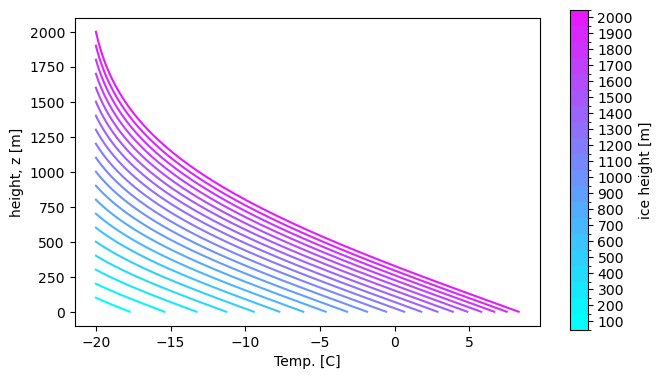

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel('Temp. [C]')
ax.set_ylabel('height, z [m]')
new_cmap = cm.get_cmap('cool', 128)
clrs4cmap= np.zeros((20, 4))
counter  = 0

for i in np.linspace(0.1, 2, 20):
    T, z = heat_model(1, 30000, 10, i*1000)
    ax.plot(T[-1,:],z, color=new_cmap(counter))
    clrs4cmap[int(counter/6), :] = new_cmap(counter)
    counter += 6
    
#colorbar
ax2    = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cmap   = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', clrs4cmap, new_cmap.N)
bounds = np.linspace(0.1, 2, 21) * 1000
labels = np.append(np.arange(100,2100,100), '')
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb     = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds+50, boundaries=bounds, label='ice height [m]')
cb.set_ticklabels(labels);

Okay, now I can look into the the model's sensitivity to reaching steasy state.

## 2. some exploring

Plotting thickness at ice divide over time of simulation. I'll use the results from the simulation I ran in the first part.

In [7]:
icedivide_thick = []
icedivide_time  = [] 
change = []

for i in np.arange(0, len(time), 5000):
    change_bystep   = H[i+1, 0] - H[i, 0]
    change = np.append(change, change_bystep)
    icedivide_thick = np.append(icedivide_thick, H[i, 0])
    icedivide_time  = np.append(icedivide_time, time[i]) 
    

In [8]:
y = np.exp(((-icedivide_time)/100))

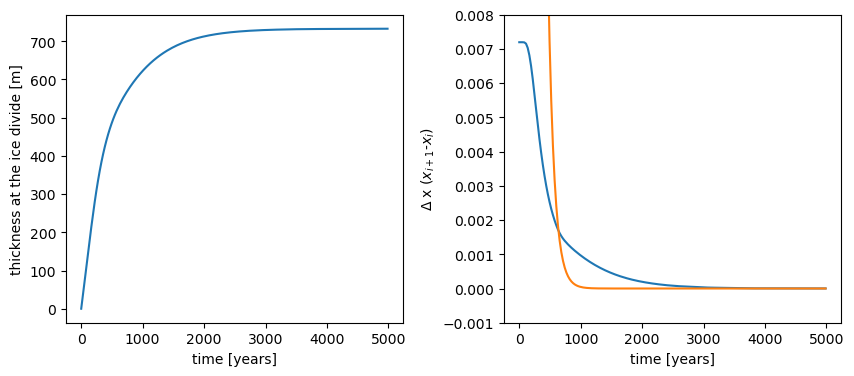

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.3)

axs[0].plot(icedivide_time, icedivide_thick)
axs[0].set_xlabel('time [years]')
axs[0].set_ylabel('thickness at the ice divide [m]')

axs[1].plot(icedivide_time, change)
axs[1].plot(icedivide_time, y)
axs[1].set_ylim([-0.001,0.008])
axs[1].set_xlabel('time [years]')
axs[1].set_ylabel('\u0394 x ($x_{i+1}$-$x_{i}$)');

Now I'm gonna take a first look into how A will effect these curves^.

In [10]:
##collecting the data##

#parameters for model
Amax    = 5 * (24*10**(-25)*60*60*24*365.4) #setting upper limit of A, value in parentheses is the 'typical' A value
A_range = np.arange(0, Amax, Amax/15)       #making array of A values from zero to Amax
dt      = 2/365                             #2 day length time step
time_tot= 5000                              #total time [years]
dx      = 200                               #spatial step
x_tot   = 40000                             #total length of ice sheet [m]

#stuff for plotting evolution
t           = np.arange(0, time_tot, dt)
evolution   = np.arange(0, len(t), 10000)
del_x       = np.zeros((len(A_range), len(evolution)))
icedivide   = np.zeros((len(A_range), len(evolution)))
short_time  = np.zeros((len(A_range), len(evolution)))
efold_times = []

for i in range(0, len(A_range)):
    
    #running the model
    print('Run',i+1,'/',len(A_range),', A =', A_range[i], ':')        #progress statement
    x, time, H, qs = ice_model(dt, time_tot, dx, x_tot, A=A_range[i])
    
    #measuring evolution
    icedivide_thick = []
    icedivide_time  = [] 
    change = []
    
    for j in evolution:
        
        change_bystep   = H[j+1, 0] - H[j, 0] #H[time, x]
        
        change          = np.append(change, change_bystep)
        icedivide_thick = np.append(icedivide_thick, H[j, 0])
        icedivide_time  = np.append(icedivide_time, time[j]) 
        
    del_x[i, :]      = change
    icedivide[i, :]  = icedivide_thick
    short_time[i, :] = icedivide_time
    
    efold = del_x[0, :][0] - (del_x[0, :][0]/math.exp(1))
    
    if i != 0:  
        dex         = H[1:, 0]-H[:-1, 0]
        difference  = np.absolute(dex-efold)
        index       = difference.argmin()
        efold_times = np.append(efold_times, time[index])
    
    

Run 1 / 15 , A = 0.0 :


100%|██████████| 912499/912499 [00:40<00:00, 22336.17it/s]


Run 2 / 15 , A = 2.5256448000000002e-17 :


100%|██████████| 912499/912499 [00:41<00:00, 22180.30it/s]


Run 3 / 15 , A = 5.0512896000000004e-17 :


100%|██████████| 912499/912499 [00:41<00:00, 22106.99it/s]


Run 4 / 15 , A = 7.576934400000001e-17 :


100%|██████████| 912499/912499 [00:40<00:00, 22340.31it/s]


Run 5 / 15 , A = 1.0102579200000001e-16 :


100%|██████████| 912499/912499 [00:40<00:00, 22358.99it/s]


Run 6 / 15 , A = 1.2628224000000002e-16 :


100%|██████████| 912499/912499 [00:40<00:00, 22426.28it/s]


Run 7 / 15 , A = 1.5153868800000002e-16 :


100%|██████████| 912499/912499 [00:40<00:00, 22437.70it/s]


Run 8 / 15 , A = 1.7679513600000002e-16 :


100%|██████████| 912499/912499 [00:40<00:00, 22322.84it/s]


Run 9 / 15 , A = 2.0205158400000002e-16 :


100%|██████████| 912499/912499 [00:40<00:00, 22348.48it/s]


Run 10 / 15 , A = 2.2730803200000004e-16 :


100%|██████████| 912499/912499 [00:40<00:00, 22296.89it/s]


Run 11 / 15 , A = 2.5256448000000004e-16 :


100%|██████████| 912499/912499 [00:40<00:00, 22374.68it/s]


Run 12 / 15 , A = 2.7782092800000004e-16 :


100%|██████████| 912499/912499 [00:41<00:00, 22149.46it/s]


Run 13 / 15 , A = 3.0307737600000004e-16 :


100%|██████████| 912499/912499 [00:40<00:00, 22326.70it/s]


Run 14 / 15 , A = 3.2833382400000003e-16 :


100%|██████████| 912499/912499 [00:41<00:00, 22252.21it/s]


Run 15 / 15 , A = 3.5359027200000003e-16 :


100%|██████████| 912499/912499 [00:40<00:00, 22364.07it/s]


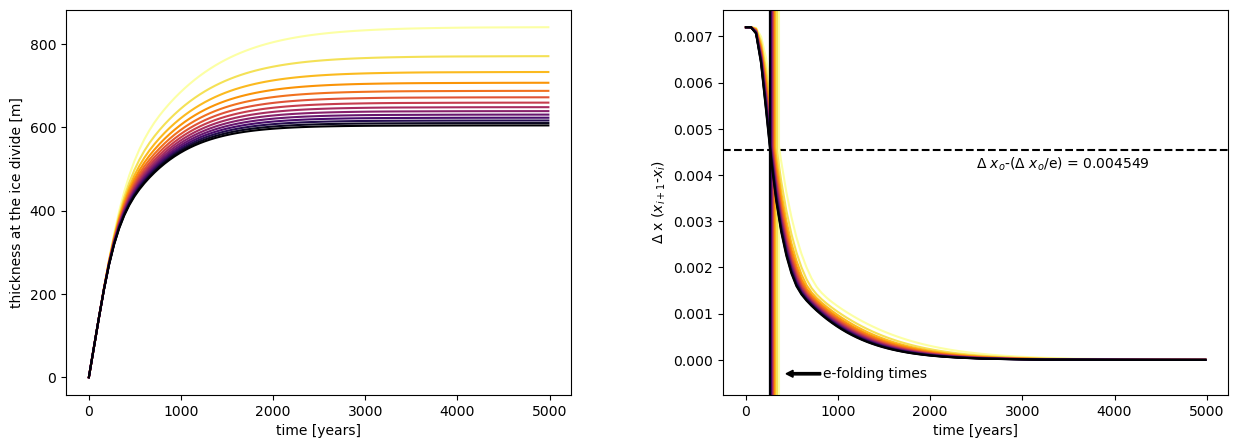

In [11]:
#setting up the figure
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)

axs[0].set_xlabel('time [years]')
axs[0].set_ylabel('thickness at the ice divide [m]')

axs[1].set_xlabel('time [years]')
axs[1].set_ylabel('\u0394 x ($x_{i+1}$-$x_{i}$)')

new_cmap = cm.get_cmap('inferno_r', 128) #making color map object to use for distiguishing various A values 

#plotting
counter = 0
for i in range(1, len(A_range)):
    axs[0].plot(short_time[i, :], icedivide[i, :], color=new_cmap(counter))
    axs[1].plot(short_time[i, :], del_x[i, :], color=new_cmap(counter))
    if i!=0:
        axs[1].axvline(x=efold_times[i-1], color=new_cmap(counter))
    counter += 10


axs[1].axhline(y=efold, color='k', linestyle='dashed', zorder=0)
axs[1].text(2500, efold-.0004, '\u0394 $x_o$-(\u0394 $x_o$/e) = '+str(round(efold, 6)))

axs[1].arrow(efold_times[-1]+550, -0.0003, -300, 0, width=0.00005, head_length=75, color='k')
axs[1].text(efold_times[-1]+580, -0.00038, 'e-folding times');

In [15]:
def efolding_rng(t, var, samp_num):
    
    ## function measures e-folding time for a range of timesteps. e-folding time should be 
    ## consistant throughout the entire run.
    
    ## VARIABLES ##
    # t   = time array
    # var = variable that evolves exponentially
    
    sample_times    = np.linspace(t.min(), t.max(), samp_num)
    sample_times_nn = np.zeros(samp_num)
    sample_vars_nn  = np.zeros(samp_num)
    counter         = 0
    
    
    for st in sample_times: 
        difference               = np.absolute(t-st)   #calculating difference between time array and sample time
        index                    = difference.argmin() #finding index of closest value
        sample_times_nn[counter] = t[index]      
        sample_vars_nn[counter]  = var[index]
        counter += 1
    
    vart_div_varo = [x/var[0] for x in sample_vars_nn]
    T_e           = sample_times_nn / np.log(vart_div_varo)
        
    return sample_times_nn, T_e

/tmp/ipykernel_339/1339752451.py:24: RuntimeWarning: invalid value encountered in divide
  T_e           = sample_times_nn / np.log(vart_div_varo)


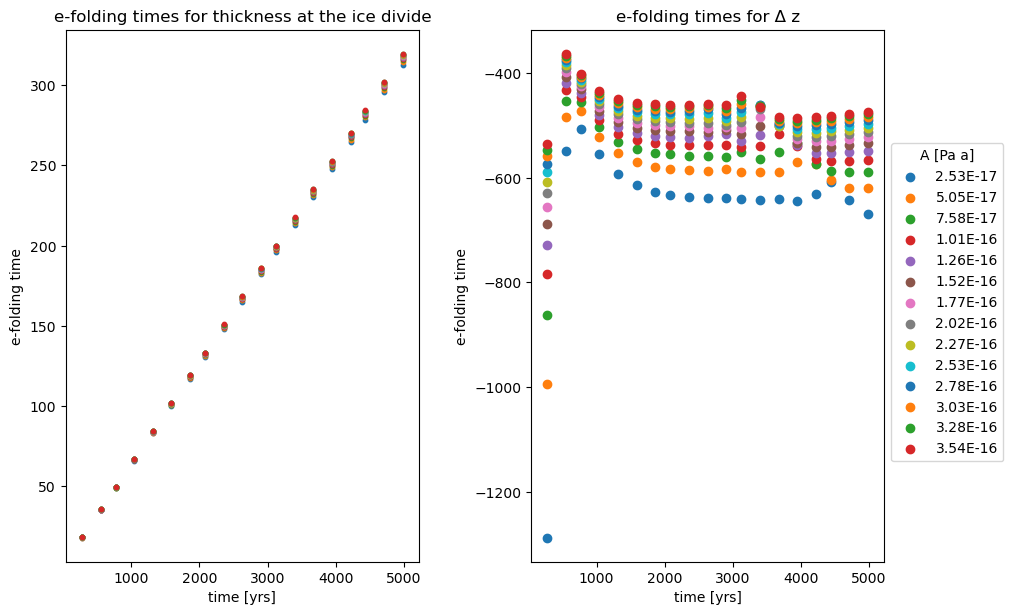

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
fig.tight_layout(pad=5.0)

Te_ices = np.zeros((20, len(A_range)-1)) #[number of sampling points, A value]
Te_delzs= np.zeros((20, len(A_range)-1))

for i in range(1, len(A_range)):
    time = short_time[i, :]
    idiv = icedivide[i, :]
    dlx  = del_x[i, :]
    time_ice, Te_ices[:, i-1]   = efolding_rng(time, idiv, 20)
    time_delz, Te_delzs[:, i-1] = efolding_rng(time, dlx, 20)
    
    axs[0].scatter(time_ice, Te_ices[:, i-1], label='%.2E' % Decimal(A_range[i]), s=10)
    axs[1].scatter(time_delz, Te_delzs[:, i-1], label='%.2E' % Decimal(A_range[i]))
    
    
    
axs[0].set_xlabel('time [yrs]')
axs[0].set_ylabel('e-folding time')
axs[0].set_title('e-folding times for thickness at the ice divide')

axs[1].legend(bbox_to_anchor=(1, 0.8), title='A [Pa a]', ncols=1)
axs[1].set_xlabel('time [yrs]')
axs[1].set_ylabel('e-folding time')
axs[1].set_title('e-folding times for \u0394 z');

In [46]:
A_range[1:]

array([2.52564480e-17, 5.05128960e-17, 7.57693440e-17, 1.01025792e-16,
       1.26282240e-16, 1.51538688e-16, 1.76795136e-16, 2.02051584e-16,
       2.27308032e-16, 2.52564480e-16, 2.77820928e-16, 3.03077376e-16,
       3.28333824e-16, 3.53590272e-16])

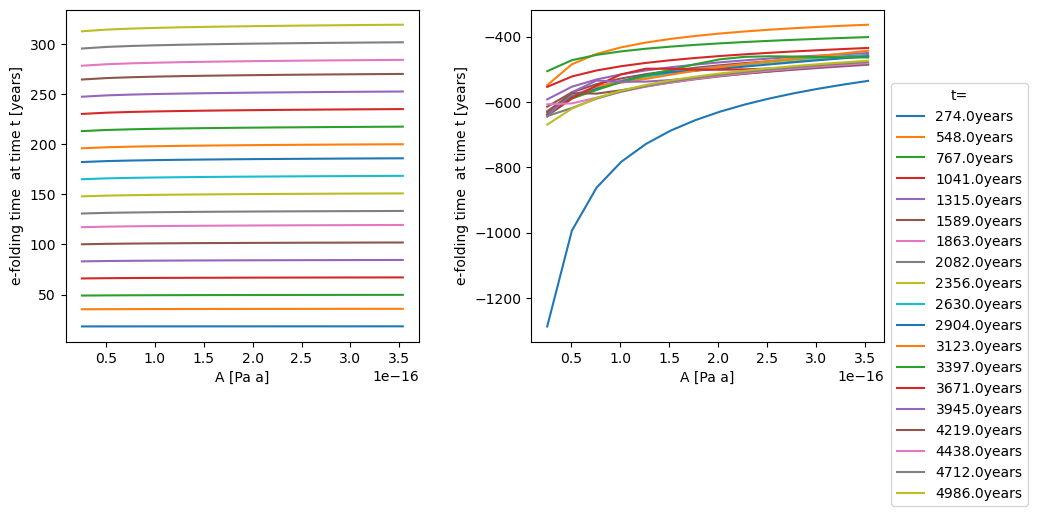

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)

for i in range(1, len(time_ice)):
    axs[0].plot(A_range[1:], Te_ices[i, :], label=str(round(time_ice[i], 0))+'years')
    axs[1].plot(A_range[1:], Te_delzs[i, :], label=str(round(time_ice[i], 0))+'years')#[number of sampling points, A value]
    
for ax in axs:
    ax.set_xlabel('A [Pa a]')
    ax.set_ylabel('e-folding time  at time t [years]')
    
axs[1].legend(bbox_to_anchor=(1, 0.8), title = 't=', ncols=1)

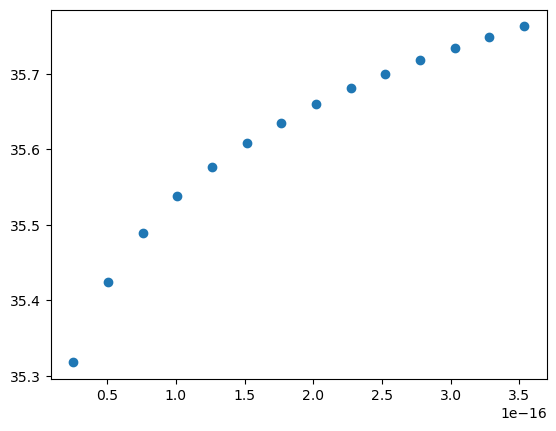

In [58]:
plt.scatter(A_range[1:], Te_ices[2, :])

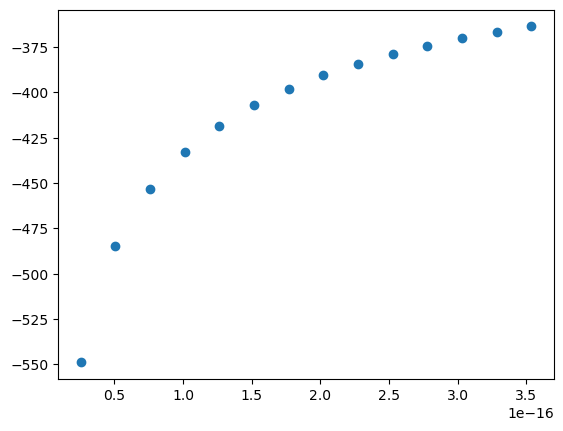

In [59]:
plt.scatter(A_range[1:], Te_delzs[2, :])

In [27]:
time = short_time[i, :]
var  = del_x[i, :]
time_delz, Te_delz = efolding_rng(time[time>=300], var[time>=300], 20)

/tmp/ipykernel_339/1339752451.py:24: RuntimeWarning: divide by zero encountered in divide
  T_e           = sample_times_nn / np.log(vart_div_varo)


In [28]:
efold_times

array([363.33150685, 333.17260274, 316.70684932, 305.52328767,
       297.11780822, 290.42191781, 284.88219178, 280.16438356,
       276.07123288, 272.46027397, 269.23287671, 266.31780822,
       263.66575342, 261.23835616])

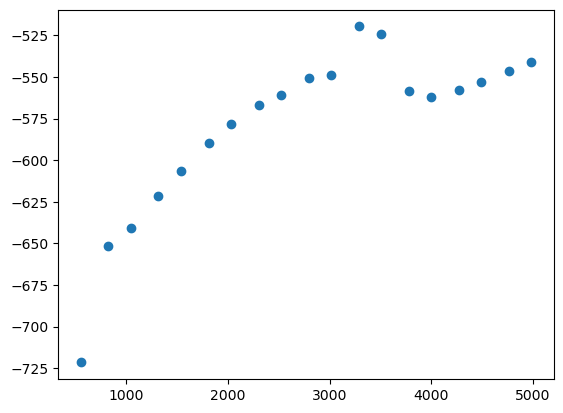

In [29]:
plt.scatter(time_delz, Te_delz)

### Dont worry abt this for now

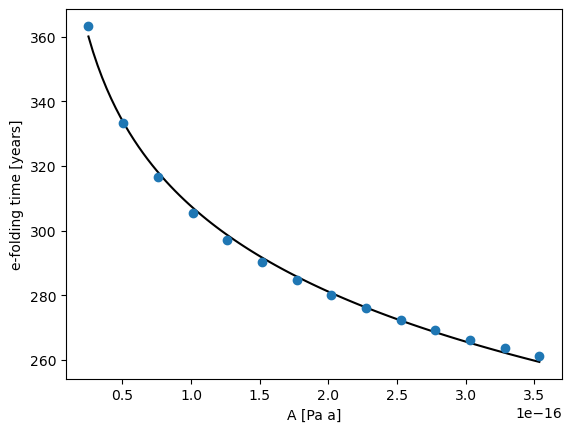

In [17]:
fig, ax = plt.subplots()

ax.scatter(A_range[1:], efold_times)
ax.set_xlabel('A [Pa a]')
ax.set_ylabel('e-folding time [years]')

x = np.linspace(A_range[1], A_range[-1], 100)
ax.plot(x, func1(x, popt[0], popt[1]), color='k', zorder=0)

#ax.plot(x, func2(x, popt2[0], popt2[1], popt2[2]), color='darkgrey');

In [13]:
from scipy.optimize import curve_fit

In [14]:
def func1(x, a, b):
    return (a * np.log(1/x)) + b

In [15]:
xdata = A_range[1:]
ydata = efold_times

In [16]:
popt, pcov = curve_fit(func1, xdata, ydata, p0=[10, 260])
print(popt)

[   38.1305363  -1097.19032691]


In [136]:
def func2(x, a, b, c):
    return a * np.exp(-b*x) + c

In [139]:
popt2, pcov2 = curve_fit(func2, xdata, ydata, p0=[1000, 1/100, 100])
print(popt2)

[ 7.16588445e+04  1.00000000e-02 -7.13673940e+04]
